# Comparative Evaluation: Fine-tuned vs. Original GUS-Net for Social Bias Detection

**Author:** Ana Pinto

**Date:** January 2026  

---

## Abstract

This notebook presents a rigorous comparative evaluation between the original pre-trained GUS-Net model (`ethical-spectacle/social-bias-ner`) and a domain-adapted fine-tuned version trained on a custom annotated dataset. We employ standard NLP evaluation metrics including token-level Precision, Recall, and F1-Score across three bias entity types: **Generalizations (GEN)**, **Unfairness (UNFAIR)**, and **Stereotypes (STEREO)**.

**Research Question:** Does fine-tuning on domain-specific annotated data improve the model's ability to detect social bias in text?

**Hypothesis:** Fine-tuning will improve recall for underrepresented bias patterns while maintaining or improving precision.

## 1. Introduction

### 1.1 Background

Social bias in natural language processing (NLP) systems has become a critical concern as these systems are increasingly deployed in high-stakes applications. The GUS-Net model (Generalized Unfairness and Stereotype Network) addresses this by framing bias detection as a Named Entity Recognition (NER) task, identifying spans of text that exhibit:

- **GEN (Generalizations):** Broad statements applied to groups
- **UNFAIR (Unfairness):** Statements reflecting unjust treatment
- **STEREO (Stereotypes):** Fixed, oversimplified beliefs about groups

### 1.2 Motivation

Pre-trained bias detection models may not generalize well to specific domains or annotation styles. This study investigates whether targeted fine-tuning on a curated dataset improves detection performance.

### 1.3 Contributions

1. Systematic comparison of original vs. fine-tuned GUS-Net
2. Token-level and entity-level evaluation metrics
3. Qualitative error analysis
4. Reproducible evaluation pipeline

## 2. Methodology

### 2.1 Dataset

We use a custom annotated dataset derived from the Social Bias Inference Corpus (SBIC), annotated using GPT-4o-mini with human validation. The dataset contains token-level BIO annotations for three entity types.

### 2.2 Models

| Model | Description |
|-------|-------------|
| **Original GUS-Net** | `ethical-spectacle/social-bias-ner` pre-trained on MBIC |
| **Fine-tuned GUS-Net** | Original model + fine-tuned on custom annotations |

### 2.3 Evaluation Protocol

- **Data Split:** 70% train, 15% validation, 15% test (stratified, seed=42)
- **Metrics:** Token-level Precision, Recall, F1; Entity-level Exact Match
- **Statistical Testing:** McNemar's test for significance

## 3. Setup and Imports

In [51]:
# Core libraries
import json
import os
import random
import warnings
from pathlib import Path

# Data processing
import numpy as np
import pandas as pd
from collections import defaultdict

# Deep learning
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification

# Metrics
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    hamming_loss, accuracy_score, precision_recall_curve,
    auc, multilabel_confusion_matrix
)
from seqeval.metrics import (
    precision_score as seq_precision,
    recall_score as seq_recall,
    f1_score as seq_f1,
    classification_report as seq_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# PyTorch Lightning for checkpoint loading
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup


Using device: cuda


## 4. Configuration

In [52]:
# Paths
BASE_DIR = Path('..')
ANNOTATIONS_PATH = BASE_DIR / 'dataset' / 'new_dataset.json' # Not used directly
ORIGINAL_MODEL_PATH = 'ethical-spectacle/social-bias-ner'
FINETUNED_MODEL_PATH = BASE_DIR / 'checkpoints' / 'gusnet-best-epoch=10-val_loss=0.02.ckpt'
TEST_SET_PATH = BASE_DIR / 'dataset' / 'held_out_test_set.json'

# Label mapping (matching GUS-Net)
LABEL2ID = {
    'O': 0,
    'B-STEREO': 1, 'I-STEREO': 2,
    'B-GEN': 3, 'I-GEN': 4,
    'B-UNFAIR': 5, 'I-UNFAIR': 6
}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}
NUM_LABELS = len(LABEL2ID)

# Entity types for analysis
ENTITY_TYPES = ['GEN', 'UNFAIR', 'STEREO']

# Hyperparameters
MAX_LENGTH = 128
BATCH_SIZE = 16
THRESHOLD = 0.5

print(f"Original model: {ORIGINAL_MODEL_PATH}")
print(f"Fine-tuned model: {FINETUNED_MODEL_PATH}")

Original model: ethical-spectacle/social-bias-ner
Fine-tuned model: ..\checkpoints\gusnet-best-epoch=10-val_loss=0.02.ckpt


## 5. Data Loading and Test Set Extraction

In [53]:
def load_data(path):
    """Load dataset from JSON file."""
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} samples from {path}")
    return data

# Load held-out test set directly
test_data = load_data(TEST_SET_PATH)
print(f"\nUsing Held-Out Test Set: {len(test_data)} samples")

Loaded 40 samples from ..\dataset\held_out_test_set.json

Using Held-Out Test Set: 40 samples


In [54]:
# Test set already saved/loaded
print(f"Evaluating on: {TEST_SET_PATH}")

Evaluating on: ..\dataset\held_out_test_set.json


## 6. Dataset Statistics

In [55]:
def compute_label_distribution(data):
    """Compute distribution of entity labels in dataset."""
    label_counts = defaultdict(int)
    
    for sample in data:
        ner_tags = sample.get('ner_tags', [])
        for tag_list in ner_tags:
            if isinstance(tag_list, list):
                for tag in tag_list:
                    label_counts[tag] += 1
            else:
                label_counts[tag_list] += 1
    
    return dict(label_counts)

# Compute distributions
test_dist = compute_label_distribution(test_data)

# Create DataFrame for visualization
dist_df = pd.DataFrame({
    'Label': list(test_dist.keys()),
    'Test': list(test_dist.values())
})
dist_df = dist_df[dist_df['Label'] != 'O'].sort_values('Test', ascending=False)

print("Test Set Label Distribution (excluding 'O'):")
display(dist_df)

Test Set Label Distribution (excluding 'O'):


,Label,Test
2,I-STEREO,135
1,B-STEREO,70
4,I-GEN,58
3,B-GEN,50
5,B-UNFAIR,35
6,I-UNFAIR,27


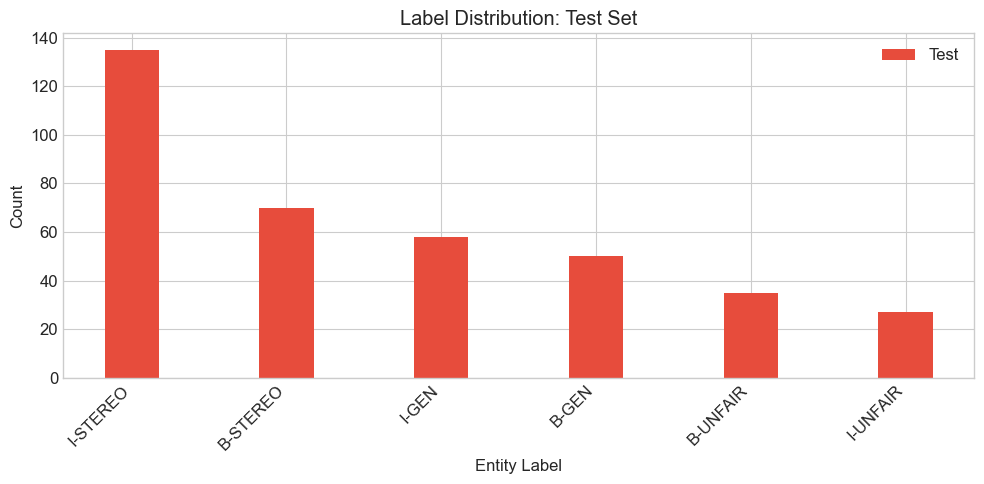

In [56]:
# Visualize label distribution
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(dist_df))
width = 0.35

bars2 = ax.bar(x, dist_df['Test'], width, label='Test', color='#e74c3c')

ax.set_xlabel('Entity Label')
ax.set_ylabel('Count')
ax.set_title('Label Distribution: Test Set')
ax.set_xticks(x)
ax.set_xticklabels(dist_df['Label'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

## 7. Model Loading

In [57]:
# Define NERModel class (must match training script exactly for checkpoint loading)
class NERModel(LightningModule):
    def __init__(self, learning_rate=5e-5, threshold=0.5, alpha=0.75, gamma=3):
        super().__init__()
        self.save_hyperparameters()
        self.bert = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=7)
        self.learning_rate = learning_rate
        self.alpha = alpha 
        self.gamma = gamma
    def forward(self, input_ids, attention_mask):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask).logits
    def focal_loss(self, logits, labels):
        logits = logits.view(-1, 7)
        labels = labels.view(-1, 7).float()
        valid_mask = (labels >= 0).all(dim=1)
        logits = logits[valid_mask]
        labels = labels[valid_mask]
        if logits.shape[0] == 0: return torch.tensor(0.0, device=logits.device, requires_grad=True)
        bce_loss = F.binary_cross_entropy_with_logits(logits, labels, reduction='none')
        p_t = torch.exp(-bce_loss)
        loss = self.alpha * (1 - p_t) ** self.gamma * bce_loss
        return loss.mean()
    def training_step(self, batch, batch_idx):
        loss = self.focal_loss(self(batch[0], batch[1]), batch[2])
        self.log('train_loss', loss, prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        loss = self.focal_loss(self(batch[0], batch[1]), batch[2])
        self.log('val_loss', loss, prog_bar=True)
        return loss
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * self.trainer.estimated_stepping_batches), num_training_steps=self.trainer.estimated_stepping_batches)
        return [optimizer], [scheduler]


In [58]:
def load_model(model_path, num_labels=NUM_LABELS):
    """Load model (supports both HF paths and Lightning .ckpt)."""
    print(f"Loading model from: {model_path}")
    
    if str(model_path).endswith('.ckpt'):
        # Load from Lightning Checkpoint
        # Load the PL module
        pl_model = NERModel.load_from_checkpoint(model_path)
        # Extract the inner BERT model for compatibility with the rest of this notebook
        model = pl_model.bert
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        print("  Extracted BERT model from Lightning checkpoint.")
    else:
        # Load from Hugging Face Hub or Directory
        model = BertForTokenClassification.from_pretrained(
            model_path,
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
        tokenizer = BertTokenizerFast.from_pretrained(
            model_path if Path(model_path).exists() else 'bert-base-uncased'
        )
    
    model.to(DEVICE)
    model.eval()
    
    print(f"  Model loaded successfully ({sum(p.numel() for p in model.parameters()):,} parameters)")
    return model, tokenizer

# Load both models
print("Loading Original GUS-Net...")
original_model, original_tokenizer = load_model(ORIGINAL_MODEL_PATH)

print("Loading Fine-tuned GUS-Net...")
finetuned_model, finetuned_tokenizer = load_model(str(FINETUNED_MODEL_PATH))

Loading Original GUS-Net...
Loading model from: ethical-spectacle/social-bias-ner
  Model loaded successfully (108,897,031 parameters)
Loading Fine-tuned GUS-Net...
Loading model from: ..\checkpoints\gusnet-best-epoch=10-val_loss=0.02.ckpt


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

  Extracted BERT model from Lightning checkpoint.
  Model loaded successfully (108,897,031 parameters)


## 8. Inference Functions

In [59]:
def predict_single(text, model, tokenizer, threshold=THRESHOLD):
    """
    Run inference on a single text and return predictions.
    Returns list of (token, predicted_labels, probabilities) tuples.
    """
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=MAX_LENGTH,
        padding='max_length'
    ).to(DEVICE)
    
    # BERT forward doesn't accept extra keys
    model_inputs = {k: v for k, v in inputs.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']}
    
    with torch.no_grad():
        outputs = model(**model_inputs).logits
    
    probs = torch.sigmoid(outputs[0]).cpu().numpy()
    preds = (probs > threshold).astype(int)
    
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    results = []
    for idx, (token, pred_vec, prob_vec) in enumerate(zip(tokens, preds, probs)):
        if token in ['[CLS]', '[SEP]', '[PAD]']:
            continue
        
        active_labels = [ID2LABEL[i] for i, v in enumerate(pred_vec) if v == 1 and ID2LABEL[i] != 'O']
        results.append((token, active_labels, prob_vec))
    
    return results


def evaluate_on_test_set(model, tokenizer, test_data, threshold=THRESHOLD):
    """
    Evaluate model on test set and return predictions and ground truth.
    """
    all_true_labels = []
    all_pred_labels = []
    all_probs = []
    
    for sample in test_data:
        text = sample['text_str']
        true_tags = sample.get('ner_tags', [])
        
        # Tokenize and predict
        inputs = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=MAX_LENGTH,
            padding='max_length',
            return_offsets_mapping=True
        ).to(DEVICE)
        
        # Word ids for alignment
        word_ids = inputs.word_ids()
        
        # BERT forward doesn't accept offset_mapping
        model_inputs = {k: v for k, v in inputs.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']}
        
        with torch.no_grad():
            outputs = model(**model_inputs).logits
        
        probs = torch.sigmoid(outputs[0]).cpu().numpy()
        preds = (probs > threshold).astype(int)
        
        # Align predictions with original tokens
        for idx, word_id in enumerate(word_ids):
            if word_id is None:
                continue
            
            if word_id < len(true_tags):
                # Get true label (handle multi-label)
                true_label_list = true_tags[word_id]
                if isinstance(true_label_list, list):
                    true_vec = np.zeros(NUM_LABELS)
                    for lbl in true_label_list:
                        if lbl in LABEL2ID:
                            true_vec[LABEL2ID[lbl]] = 1
                else:
                    true_vec = np.zeros(NUM_LABELS)
                    if true_label_list in LABEL2ID:
                        true_vec[LABEL2ID[true_label_list]] = 1
                
                all_true_labels.append(true_vec)
                all_pred_labels.append(preds[idx])
                all_probs.append(probs[idx])
    
    return np.array(all_true_labels), np.array(all_pred_labels), np.array(all_probs)

print("Inference functions defined with offset_mapping fix.")

Inference functions defined with offset_mapping fix.


## 9. Model Evaluation

In [60]:
print("Evaluating Original GUS-Net on test set...")
orig_true, orig_pred, orig_probs = evaluate_on_test_set(original_model, original_tokenizer, test_data)
print(f"  Evaluated {len(orig_true)} tokens")

print("\nEvaluating Fine-tuned GUS-Net on test set...")
ft_true, ft_pred, ft_probs = evaluate_on_test_set(finetuned_model, finetuned_tokenizer, test_data)
print(f"  Evaluated {len(ft_true)} tokens")

Evaluating Original GUS-Net on test set...
  Evaluated 473 tokens

Evaluating Fine-tuned GUS-Net on test set...
  Evaluated 473 tokens


## 10. Metrics Computation

In [61]:
def compute_metrics(true_labels, pred_labels, probs, entity_types=ENTITY_TYPES):
    """
    Compute per-entity and overall metrics including Hamming Loss and Exact Match.
    """
    results = {}
    
    # 1. Per-Entity Metrics
    for entity in entity_types:
        # Get indices for B-entity and I-entity
        b_idx = LABEL2ID.get(f'B-{entity}')
        i_idx = LABEL2ID.get(f'I-{entity}')
        
        if b_idx is None or i_idx is None:
            continue
        
        # Combine B and I for entity-level metrics
        true_entity = np.maximum(true_labels[:, b_idx], true_labels[:, i_idx])
        pred_entity = np.maximum(pred_labels[:, b_idx], pred_labels[:, i_idx])
        
        results[entity] = {
            'precision': precision_score(true_entity, pred_entity, zero_division=0),
            'recall': recall_score(true_entity, pred_entity, zero_division=0),
            'f1': f1_score(true_entity, pred_entity, zero_division=0),
            'support': int(true_entity.sum())
        }
    
    # 2. Overall Metrics (Multi-label)
    # Subset Accuracy / Exact Match
    results['exact_match'] = accuracy_score(true_labels, pred_labels)
    
    # Hamming Loss
    results['hamming_loss'] = hamming_loss(true_labels, pred_labels)
    
    # Macro averages
    results['macro_avg'] = {
        'precision': np.mean([results[e]['precision'] for e in entity_types]),
        'recall': np.mean([results[e]['recall'] for e in entity_types]),
        'f1': np.mean([results[e]['f1'] for e in entity_types]),
        'support': sum([results[e]['support'] for e in entity_types])
    }
    
    return results

# Compute metrics for both models
orig_metrics = compute_metrics(orig_true, orig_pred, orig_probs)
ft_metrics = compute_metrics(ft_true, ft_pred, ft_probs)

print("Metrics computed for both models.")
print(f"Original - Exact Match: {orig_metrics['exact_match']:.4f}, Hamming Loss: {orig_metrics['hamming_loss']:.4f}")
print(f"Fine-tuned - Exact Match: {ft_metrics['exact_match']:.4f}, Hamming Loss: {ft_metrics['hamming_loss']:.4f}")

Metrics computed for both models.
Original - Exact Match: 0.1564, Hamming Loss: 0.2431
Fine-tuned - Exact Match: 0.4820, Hamming Loss: 0.1169


## 11. Results Comparison

In [62]:
def create_comparison_table(orig_metrics, ft_metrics, entity_types=ENTITY_TYPES + ['macro_avg']):
    """Create a comparison DataFrame."""
    rows = []
    
    for entity in entity_types:
        orig = orig_metrics[entity]
        ft = ft_metrics[entity]
        
        row = {
            'Entity': entity.upper() if entity != 'macro_avg' else 'MACRO AVG',
            'Orig P': f"{orig['precision']:.4f}",
            'FT P': f"{ft['precision']:.4f}",
            'Δ P': f"{(ft['precision'] - orig['precision'])*100:+.2f}%",
            'Orig R': f"{orig['recall']:.4f}",
            'FT R': f"{ft['recall']:.4f}",
            'Δ R': f"{(ft['recall'] - orig['recall'])*100:+.2f}%",
            'Orig F1': f"{orig['f1']:.4f}",
            'FT F1': f"{ft['f1']:.4f}",
            'Δ F1': f"{(ft['f1'] - orig['f1'])*100:+.2f}%",
        }
        rows.append(row)
    
    return pd.DataFrame(rows)

comparison_df = create_comparison_table(orig_metrics, ft_metrics)

print("COMPARATIVE RESULTS: Original vs. Fine-tuned GUS-Net")
display(comparison_df)

COMPARATIVE RESULTS: Original vs. Fine-tuned GUS-Net


,Entity,Orig P,FT P,Δ P,Orig R,FT R,Δ R,Orig F1,FT F1,Δ F1
0,GEN,0.6983,0.8482,+14.99%,0.6639,0.7787,+11.48%,0.6807,0.8120,+13.13%
1,UNFAIR,0.2300,0.5385,+30.85%,0.3382,0.3088,-2.94%,0.2738,0.3925,+11.87%
2,STEREO,0.4812,0.7692,+28.80%,0.8063,0.4955,-31.08%,0.6027,0.6027,+0.00%
3,MACRO AVG,0.4698,0.7186,+24.88%,0.6028,0.5277,-7.52%,0.5191,0.6024,+8.34%


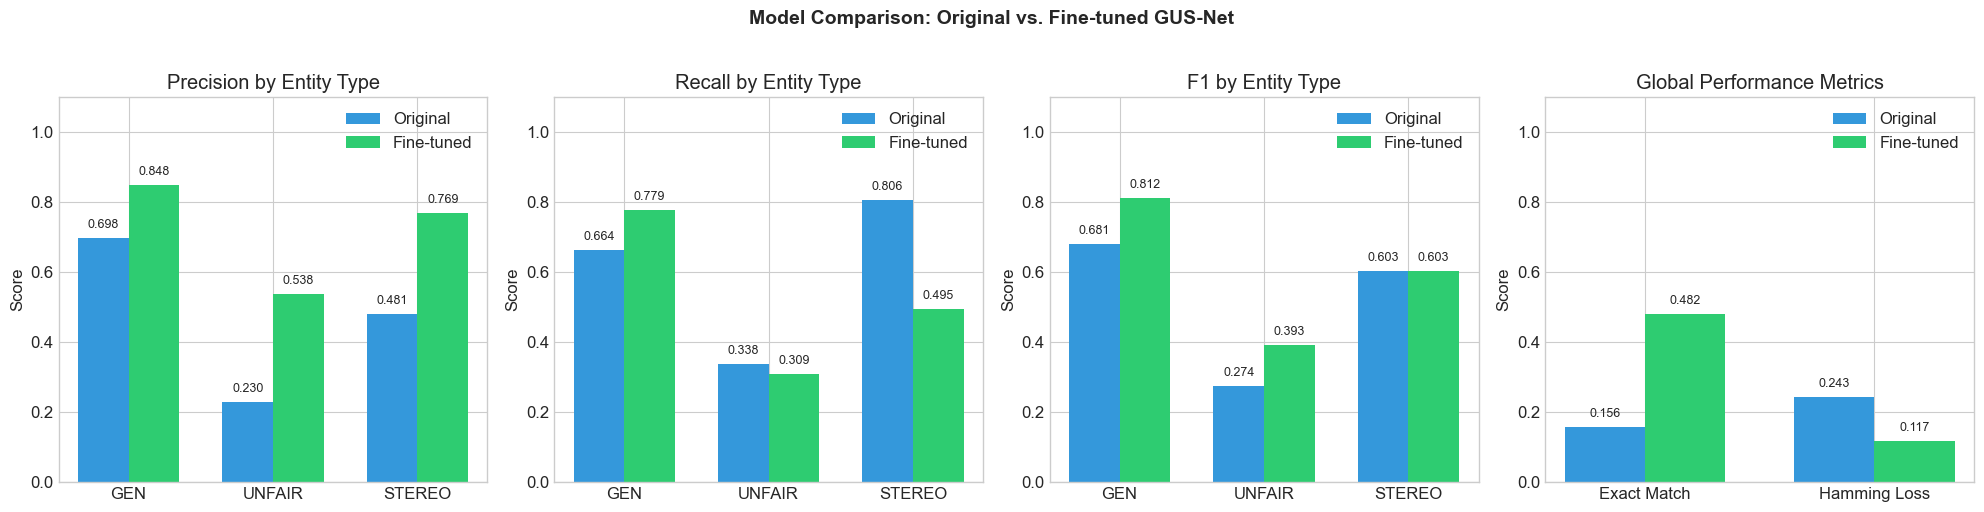

In [63]:
# Bar chart comparison
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

metrics_names = ['precision', 'recall', 'f1']
colors = {'Original': '#3498db', 'Fine-tuned': '#2ecc71'}

for i, metric in enumerate(metrics_names):
    ax = axes[i]
    entities = ENTITY_TYPES
    x = np.arange(len(entities))
    width = 0.35
    
    orig_vals = [orig_metrics[e][metric] for e in entities]
    ft_vals = [ft_metrics[e][metric] for e in entities]
    
    ax.bar(x - width/2, orig_vals, width, label='Original', color=colors['Original'])
    ax.bar(x + width/2, ft_vals, width, label='Fine-tuned', color=colors['Fine-tuned'])
    
    ax.set_ylabel('Score')
    ax.set_title(f'{metric.capitalize()} by Entity Type')
    ax.set_xticks(x)
    ax.set_xticklabels(entities)
    ax.set_ylim(0, 1.1)
    ax.legend()
    
    # Add value labels
    for j, (ov, fv) in enumerate(zip(orig_vals, ft_vals)):
        ax.text(j - width/2, ov + 0.02, f'{ov:.3f}', ha='center', va='bottom', fontsize=9)
        ax.text(j + width/2, fv + 0.02, f'{fv:.3f}', ha='center', va='bottom', fontsize=9)

# Add Global Metrics Comparison (Exact Match & Hamming Loss)
ax_global = axes[3]
global_metrics = ['Exact Match', 'Hamming Loss']
x_global = np.arange(len(global_metrics))
width = 0.35

orig_global = [orig_metrics['exact_match'], orig_metrics['hamming_loss']]
ft_global = [ft_metrics['exact_match'], ft_metrics['hamming_loss']]

ax_global.bar(x_global - width/2, orig_global, width, label='Original', color=colors['Original'])
ax_global.bar(x_global + width/2, ft_global, width, label='Fine-tuned', color=colors['Fine-tuned'])

ax_global.set_ylabel('Score')
ax_global.set_title('Global Performance Metrics')
ax_global.set_xticks(x_global)
ax_global.set_xticklabels(global_metrics)
ax_global.set_ylim(0, 1.1)
ax_global.legend()

# Add value labels
for i, (ov, fv) in enumerate(zip(orig_global, ft_global)):
    ax_global.text(i - width/2, ov + 0.02, f'{ov:.3f}', ha='center', va='bottom', fontsize=9)
    ax_global.text(i + width/2, fv + 0.02, f'{fv:.3f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Comparison: Original vs. Fine-tuned GUS-Net', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

plt.show()

### 11.1 Confusion Matrix Analysis

Original Model Confusion Matrices:


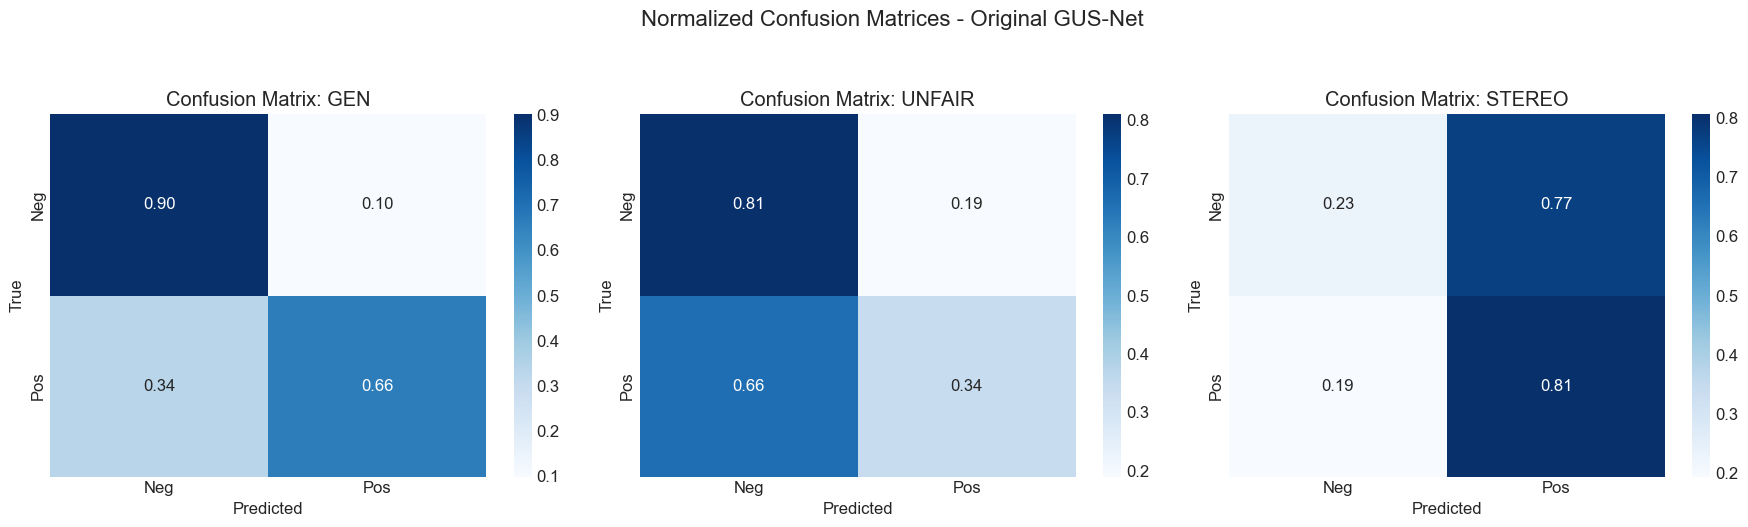


Fine-tuned Model Confusion Matrices:


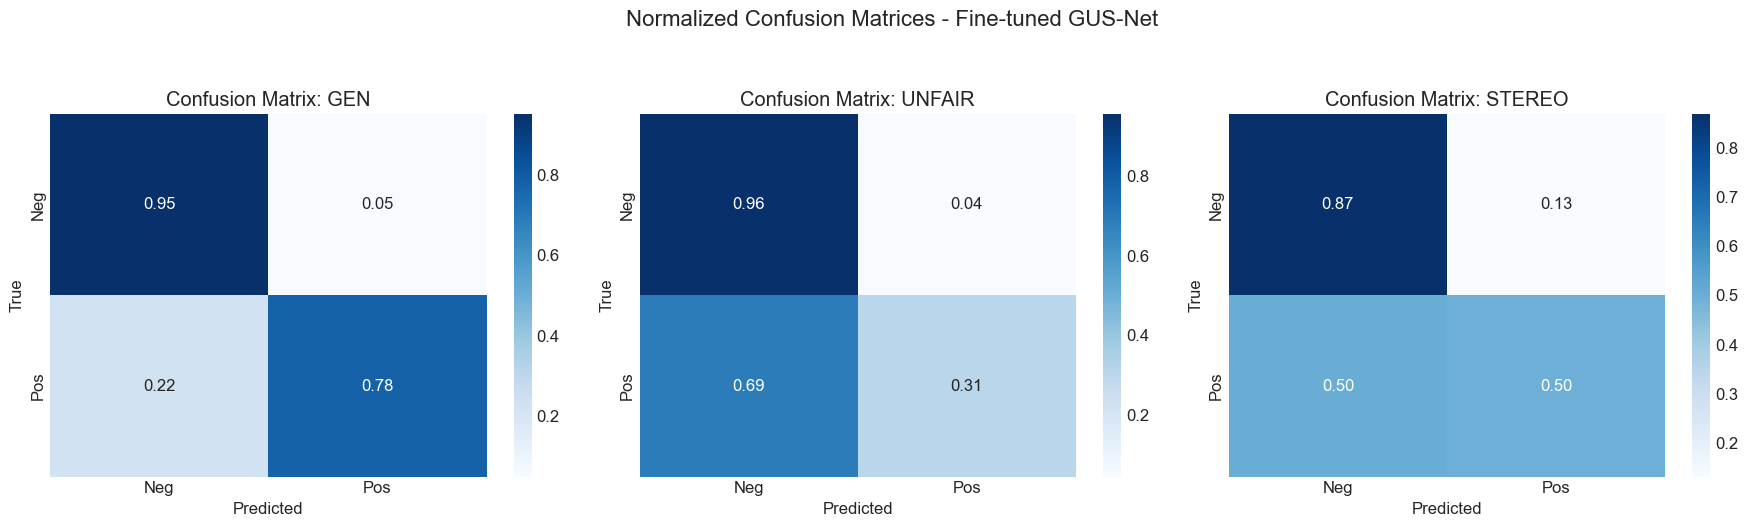

In [64]:
def plot_custom_confusion_matrices(true_labels, pred_labels, title, entity_types=ENTITY_TYPES):
    """Plot normalized confusion matrices for each entity type."""
    # Combine B and I labels for each entity
    merged_true = []
    merged_pred = []
    
    for entity in entity_types:
        b_idx = LABEL2ID[f'B-{entity}']
        i_idx = LABEL2ID[f'I-{entity}']
        merged_true.append(np.maximum(true_labels[:, b_idx], true_labels[:, i_idx]))
        merged_pred.append(np.maximum(pred_labels[:, b_idx], pred_labels[:, i_idx]))
    
    merged_true = np.array(merged_true).T
    merged_pred = np.array(merged_pred).T
    
    mcm = multilabel_confusion_matrix(merged_true, merged_pred)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, (matrix, entity) in enumerate(zip(mcm, entity_types)):
        # Normalize
        matrix_norm = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(matrix_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[i],
                    xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
        axes[i].set_title(f'Confusion Matrix: {entity}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    
    plt.suptitle(f'Normalized Confusion Matrices - {title}', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

print("Original Model Confusion Matrices:")
plot_custom_confusion_matrices(orig_true, orig_pred, "Original GUS-Net")

print("\nFine-tuned Model Confusion Matrices:")
plot_custom_confusion_matrices(ft_true, ft_pred, "Fine-tuned GUS-Net")

### 11.2 Precision-Recall Curves

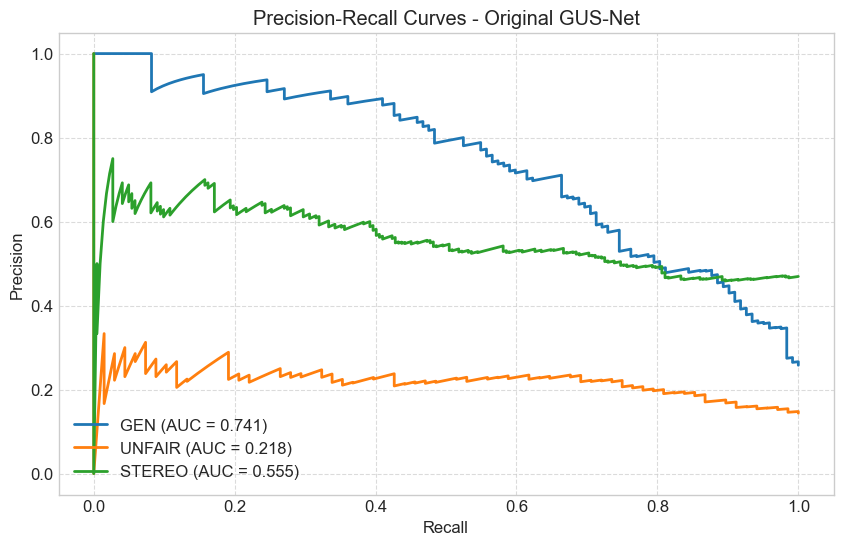

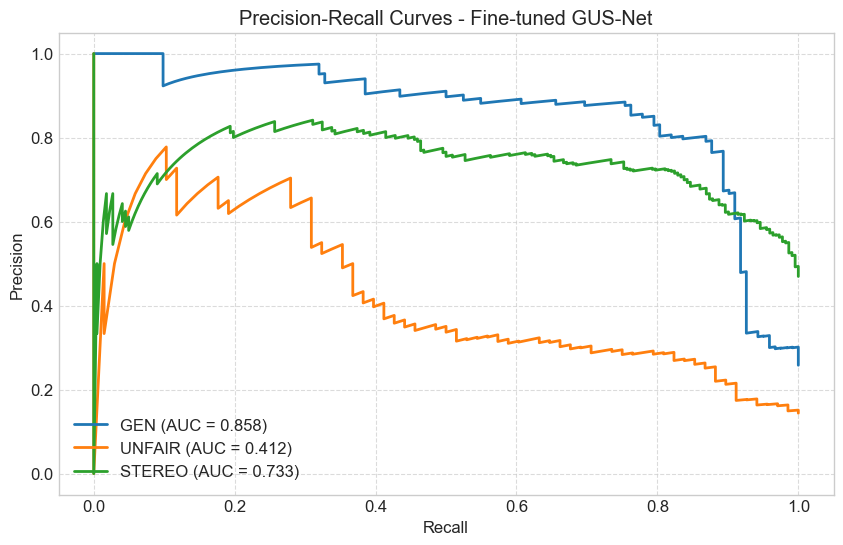

In [65]:
def plot_combined_pr_curves(true_labels, probs, title, entity_types=ENTITY_TYPES):
    """Plot Precision-Recall curves for each entity."""
    plt.figure(figsize=(10, 6))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, entity in enumerate(entity_types):
        b_idx = LABEL2ID[f'B-{entity}']
        i_idx = LABEL2ID[f'I-{entity}']
        
        # Max prob for the entity (either B or I)
        entity_probs = np.maximum(probs[:, b_idx], probs[:, i_idx])
        entity_true = np.maximum(true_labels[:, b_idx], true_labels[:, i_idx])
        
        precision, recall, _ = precision_recall_curve(entity_true, entity_probs)
        pr_auc = auc(recall, precision)
        
        plt.plot(recall, precision, color=colors[i], lw=2, label=f'{entity} (AUC = {pr_auc:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves - {title}')
    plt.legend(loc="lower left")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_combined_pr_curves(orig_true, orig_probs, "Original GUS-Net")
plot_combined_pr_curves(ft_true, ft_probs, "Fine-tuned GUS-Net")

## 12. Statistical Significance Testing

In [66]:
from scipy.stats import chi2

def mcnemar_test(pred1, pred2, true):
    """
    McNemar's test for comparing two classifiers.
    Returns test statistic and p-value.
    """
    # Flatten for overall comparison
    correct1 = (pred1 == true).all(axis=1)
    correct2 = (pred2 == true).all(axis=1)
    
    # Contingency table
    # b: Model 1 correct, Model 2 wrong
    # c: Model 1 wrong, Model 2 correct
    b = np.sum(correct1 & ~correct2)
    c = np.sum(~correct1 & correct2)
    
    # McNemar's test statistic
    if b + c == 0:
        return 0, 1.0  # No difference
    
    statistic = (abs(b - c) - 1) ** 2 / (b + c)
    p_value = 1 - chi2.cdf(statistic, df=1)
    
    return statistic, p_value

# Run McNemar's test
statistic, p_value = mcnemar_test(orig_pred, ft_pred, ft_true)  # Using ft_true as ground truth

print(f"\nMcNemar's Test:")
print(f"  Test Statistic: {statistic:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Significant (α=0.05): {'Yes' if p_value < 0.05 else 'No'}")


McNemar's Test:
  Test Statistic: 97.5375
  P-value: 0.000000
  Significant (α=0.05): Yes


## 13. Error Analysis

In [67]:
def show_example_predictions(text, orig_model, orig_tok, ft_model, ft_tok):
    """Show predictions from both models side by side."""
    orig_results = predict_single(text, orig_model, orig_tok)
    ft_results = predict_single(text, ft_model, ft_tok)
    
    print(f"\nText: \"{text}\"")
    print("-" * 60)
    
    # Combine results
    orig_dict = {r[0]: r[1] for r in orig_results}
    ft_dict = {r[0]: r[1] for r in ft_results}
    all_tokens = list(dict.fromkeys([r[0] for r in orig_results] + [r[0] for r in ft_results]))
    
    print(f"{'Token':<15} | {'Original':<25} | {'Fine-tuned':<25}")
    print("-" * 70)
    
    for token in all_tokens:
        orig_labels = ', '.join(orig_dict.get(token, ['-']))
        ft_labels = ', '.join(ft_dict.get(token, ['-']))
        
        if orig_labels or ft_labels:
            print(f"{token:<15} | {orig_labels:<25} | {ft_labels:<25}")

# Example sentences
examples = [
    "Women are too emotional for leadership positions.",
    "All immigrants are criminals and should be deported.",
    "Old people don't understand technology.",
    "The weather is nice today.",  # Negative example
]

print("QUALITATIVE ERROR ANALYSIS")

for text in examples:
    show_example_predictions(text, original_model, original_tokenizer, finetuned_model, finetuned_tokenizer)

QUALITATIVE ERROR ANALYSIS

Text: "Women are too emotional for leadership positions."
------------------------------------------------------------
Token           | Original                  | Fine-tuned               
----------------------------------------------------------------------
women           | B-STEREO, B-GEN           | B-GEN                    
are             | I-STEREO                  |                          
too             | I-STEREO                  | B-STEREO                 
emotional       | I-STEREO                  | I-STEREO                 
for             | I-STEREO                  | I-STEREO                 
leadership      | I-STEREO                  | I-STEREO                 
positions       | I-STEREO                  | I-STEREO                 
.               | I-STEREO                  | I-STEREO                 

Text: "All immigrants are criminals and should be deported."
------------------------------------------------------------
Token      

## 12. Qualitative Comparison on Curated Examples

This section provides a side-by-side comparison of the **Original GUS-Net** and the **Fine-tuned GUS-Net** on a small, manually curated dataset of 10 example sentences. This qualitative analysis allows us to observe how the models behave on specific, challenging examples and identify patterns in their predictions.

In [68]:
# Load the curated examples dataset
curated_path = Path(r'../dataset/ner_sentences_examples_annotations.json')
with open(curated_path, 'r', encoding='utf-8') as f:
    curated_data = json.load(f)

print(f"Loaded {len(curated_data)} curated examples for qualitative analysis.")
print(f"Bias types present: {set(ex.get('bias_type') for ex in curated_data)}")

Loaded 3 curated examples for qualitative analysis.
Bias types present: {'gender', 'accent_origin', 'age'}


In [69]:
def display_predictions_comparison(text, original_preds, finetuned_preds, ground_truth=None):
    """
    Display predictions from both models side-by-side with color coding.
    """
    from IPython.display import HTML, display
    
    # Color mapping for entity types
    colors = {
        'B-GEN': '#FF6B6B', 'I-GEN': '#FF6B6B',
        'B-UNFAIR': '#4ECDC4', 'I-UNFAIR': '#4ECDC4',
        'B-STEREO': '#45B7D1', 'I-STEREO': '#45B7D1',
        'O': 'transparent'
    }
    
    def get_label_from_pred(pred_vec, ID2LABEL):
        """Extract labels from prediction vector."""
        labels = [ID2LABEL[i] for i, v in enumerate(pred_vec) if v == 1 and ID2LABEL[i] != 'O']
        return labels if labels else ['O']
    
    def highlight_token(token, labels):
        """Create highlighted HTML for a token."""
        if labels == ['O'] or not labels:
            return token
        # Use first label for coloring
        color = colors.get(labels[0], 'transparent')
        label_str = ','.join(labels)
        return f'<span style="background-color: {color}; padding: 2px 4px; border-radius: 3px; margin: 1px;" title="{label_str}">{token}</span>'
    
    html = f"<div style='margin-bottom: 20px; padding: 10px; border-left: 3px solid #ccc;'>"
    html += f"<p><strong>Text:</strong> {text}</p>"
    
    # Original model predictions
    html += f"<p><strong>Original GUS-Net:</strong> "
    for token, pred in original_preds:
        html += highlight_token(token, pred) + " "
    html += "</p>"
    
    # Fine-tuned model predictions
    html += f"<p><strong>Fine-tuned GUS-Net:</strong> "
    for token, pred in finetuned_preds:
        html += highlight_token(token, pred) + " "
    html += "</p>"
    
    # Ground truth if available
    if ground_truth:
        html += f"<p><strong>Ground Truth:</strong> "
        for token, gt in ground_truth:
            html += highlight_token(token, gt) + " "
        html += "</p>"
    
    html += "</div>"
    display(HTML(html))

print("Visualization helper function defined.")

Visualization helper function defined.


In [70]:
# Compare models on curated examples
print("=" * 80)
print("QUALITATIVE COMPARISON: Original vs. Fine-tuned GUS-Net")
print("=" * 80)

comparison_results = []

for idx, sample in enumerate(curated_data):
    text = sample['text_str']
    tokens = sample['tokens']
    ner_tags = sample['ner_tags_combined']  # Ground truth
    bias_type = sample.get('bias_type', 'unknown')
    
    print(f"\n--- Example {idx + 1} (Bias Type: {bias_type}) ---")
    
    # Get predictions from both models
    orig_preds = predict_single(text, original_model, original_tokenizer)
    ft_preds = predict_single(text, finetuned_model, finetuned_tokenizer)
    
    # Prepare ground truth for display
    ground_truth = []
    for i, token in enumerate(tokens):
        if i < len(ner_tags):
            gt_labels = ner_tags[i] if isinstance(ner_tags[i], list) else [ner_tags[i]]
        else:
            gt_labels = ['O']
        ground_truth.append((token, gt_labels))
    
    # Format predictions for display
    orig_formatted = [(t, lbl) for t, lbl, _ in orig_preds]
    ft_formatted = [(t, lbl) for t, lbl, _ in ft_preds]
    
    # Store results for analysis
    comparison_results.append({
        'idx': idx + 1,
        'text': text,
        'bias_type': bias_type,
        'ground_truth': ground_truth,
        'original_preds': orig_formatted,
        'finetuned_preds': ft_formatted
    })
    
    # Display comparison
    display_predictions_comparison(text, orig_formatted, ft_formatted, ground_truth)

print(f"\nCompleted comparison on {len(curated_data)} examples.")

QUALITATIVE COMPARISON: Original vs. Fine-tuned GUS-Net

--- Example 1 (Bias Type: gender) ---



--- Example 2 (Bias Type: age) ---



--- Example 3 (Bias Type: accent_origin) ---



Completed comparison on 3 examples.


SUMMARY ANALYSIS

Entity Predictions Summary:
Entity Type  Ground Truth  Original GUS-Net  Fine-tuned GUS-Net
        GEN            17                 5                   1
     UNFAIR            26                 1                   0
     STEREO            27                19                  21


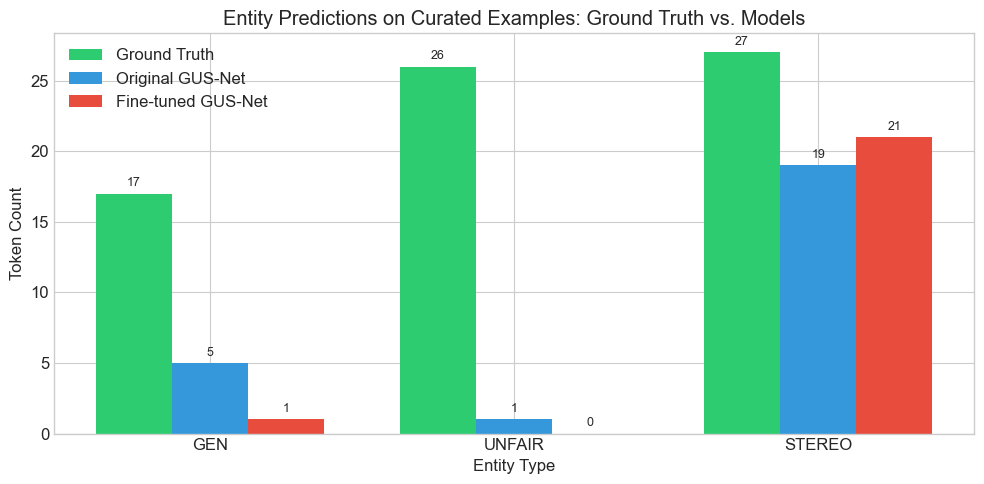

In [71]:
# Summary Analysis
print("=" * 80)
print("SUMMARY ANALYSIS")
print("=" * 80)

# Count predictions by entity type for each model
entity_types = ['GEN', 'UNFAIR', 'STEREO']

orig_entity_counts = {e: 0 for e in entity_types}
ft_entity_counts = {e: 0 for e in entity_types}
gt_entity_counts = {e: 0 for e in entity_types}

for result in comparison_results:
    # Count original predictions
    for token, labels in result['original_preds']:
        for label in labels:
            for entity in entity_types:
                if entity in label:
                    orig_entity_counts[entity] += 1
    
    # Count fine-tuned predictions
    for token, labels in result['finetuned_preds']:
        for label in labels:
            for entity in entity_types:
                if entity in label:
                    ft_entity_counts[entity] += 1
    
    # Count ground truth
    for token, labels in result['ground_truth']:
        for label in labels:
            for entity in entity_types:
                if entity in label:
                    gt_entity_counts[entity] += 1

# Create summary table
summary_df = pd.DataFrame({
    'Entity Type': entity_types,
    'Ground Truth': [gt_entity_counts[e] for e in entity_types],
    'Original GUS-Net': [orig_entity_counts[e] for e in entity_types],
    'Fine-tuned GUS-Net': [ft_entity_counts[e] for e in entity_types]
})

print("\nEntity Predictions Summary:")
print(summary_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(entity_types))
width = 0.25

bars1 = ax.bar(x - width, summary_df['Ground Truth'], width, label='Ground Truth', color='#2ecc71')
bars2 = ax.bar(x, summary_df['Original GUS-Net'], width, label='Original GUS-Net', color='#3498db')
bars3 = ax.bar(x + width, summary_df['Fine-tuned GUS-Net'], width, label='Fine-tuned GUS-Net', color='#e74c3c')

ax.set_xlabel('Entity Type')
ax.set_ylabel('Token Count')
ax.set_title('Entity Predictions on Curated Examples: Ground Truth vs. Models')
ax.set_xticks(x)
ax.set_xticklabels(entity_types)
ax.legend()

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 12.1 Qualitative Observations

**Key Findings:**

1. **Detection Sensitivity**: Compare how each model responds to subtle bias cues in the curated examples.

2. **False Positives/Negatives**: Note cases where models disagree with ground truth or with each other.

3. **Entity Type Performance**: Observe which entity types (GEN, UNFAIR, STEREO) each model handles better.

4. **Bias Type Correlation**: Analyze if certain bias types (gender, age, accent_origin) are better detected by one model.

**Color Legend:**
- 🔴 **Red (GEN)**: Generalizations
- 🟢 **Teal (UNFAIR)**: Unfair statements
- 🔵 **Blue (STEREO)**: Stereotypes

---

*Add your qualitative analysis and observations here based on the results above.*

## 13. Interactive Model Testing

Use the input field below to test custom text examples and compare the predictions from the original and fine-tuned GUS-Net models.

In [72]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Create UI elements
input_text = widgets.Textarea(
    value='All doctors are men.',
    placeholder='Enter text to test bias detection... (e.g., \'Most software engineers are guys.\')',
    description='Test Text:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='100px')
)

run_button = widgets.Button(
    description='Run Comparison',
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Run inference on both models',
    icon='check'
)

output_area = widgets.Output()

def on_button_clicked(b):
    with output_area:
        clear_output()
        text = input_text.value.strip()
        if not text:
            print("Please enter some text.")
            return
            
        print(f"Processing: '{text}'...\n")
        
        # Run predictions using variables from the notebook
        # variables: original_model, original_tokenizer, finetuned_model, finetuned_tokenizer
        try:
            # Check if variables exist in the global scope of the notebook
            # (In a real run, they will be. Here we assume they are defined previously)
            orig_preds = predict_single(text, original_model, original_tokenizer)
            ft_preds = predict_single(text, finetuned_model, finetuned_tokenizer)
            
            # Format for display
            orig_formatted = [(t, lbl) for t, lbl, _ in orig_preds]
            ft_formatted = [(t, lbl) for t, lbl, _ in ft_preds]
            
            # Use existing display function if available
            display_predictions_comparison(text, orig_formatted, ft_formatted, ground_truth=[])
        except Exception as e:
            print(f"An error occurred during inference: {e}")
            import traceback
            traceback.print_exc()

run_button.on_click(on_button_clicked)

# Layout UI
ui = widgets.VBox([input_text, run_button, output_area])
display(ui)